In [33]:
import librosa
import soundfile
import tqdm
from scipy.io import wavfile
import glob
import os,pickle
import numpy as np
from spafe.features.mfcc import mfcc, imfcc
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras.models import Sequential
#from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

In [34]:
def norm_(x,mean = False):
    if mean == True:
        return (x - np.mean(x)) / (np.max(x) - np.min(x)) #normalization                             
    else:
        return (x-np.mean(x)/np.std(x)) #standardization

def zero_handling(x):
    """
    handle the issue with zero values if they are exposed to become an argument
    for any log function.

    Returns:
        vector with zeros substituted with epsilon values.
    """
    return np.where(x == float(0), np.finfo(float).eps, x)

In [35]:
def mfcc_(sig,fs):
    mfccs  = mfcc(sig, fs=fs, num_ceps=20, pre_emph=1, pre_emph_coeff=0.95, 
              win_len=0.025, win_hop=0.01, win_type='hamming', nfilts=26, 
              nfft=512, low_freq=None, high_freq=None, scale='constant', 
              dct_type=2, use_energy=False, lifter=22)
    #print(fs)
    return mfccs

In [36]:
def label(user,total): # its creating lable for splited audio data
    k_train = []
    for i in range(total):
        k_train.append(user)
    y_train=np.array(k_train).T
    return y_train

In [37]:
def s2c(mfcc=False,lpcc=False):
    x,y=[],[]
    data = np.empty([1,148,20])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    for file in tqdm(glob.iglob('G:\LibriSpeech\dev-clean\\**/*.flac', recursive=True)):
        file_name=os.path.basename(file)
        user = file_name.split("-")[0]
        #print(f)
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        signal = norm_(signal,mean = False)
        signal = zero_handling(signal)
        
        if mfcc:
            feature = mfcc_(signal,sr)
            #print(feature.shape[0])
        if lpcc:
            feature = lpcc_(signal,sr)   
        #if feature.shape[0]>256:
        
        quotient = int(feature.shape[0]/148)
        end_index = feature.shape[0]-(feature.shape[0]%148)
        r = feature[0:end_index,:]
        re_data = np.reshape(r,(-1,148,20))#b = np.reshape(a, (8, 3, -1))
        data=np.concatenate((data,re_data),axis=0)
        
        re_label = label(user,quotient)
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:,:],data_label      

In [38]:
def s2c(mfcc=False,lpcc=False):
    x,y=[],[]
    data = np.empty([1,148,20])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    for file in tqdm(glob.iglob('G:\LibriSpeech\dev-clean\\**/*.flac', recursive=True)):
        file_name=os.path.basename(file)
        user = file_name.split("-")[0]
        #print(f)
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        #signal = norm_(signal,mean = True)
        #signal = zero_handling(signal)
        
        if mfcc:
            feature = mfcc_(signal,sr)
            #print(feature.shape[0])
        if lpcc:
            feature = lpcc_(signal,sr)   
        #if feature.shape[0]>256:
        
        quotient = int(feature.shape[0]/148)
        end_index = feature.shape[0]-(feature.shape[0]%148)
        r = feature[0:end_index,:]
        re_data = np.reshape(r,(-1,148,20))#b = np.reshape(a, (8, 3, -1))
        data=np.concatenate((data,re_data),axis=0)
        
        re_label = label(user,quotient)
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:,:],data_label

In [39]:
%%time
def write_(x,y):
    with open('mfcc_data.csv', 'a') as mfcc_dataFile:
        writer = csv.writer(mfcc_dataFile)
        writer.writerows(x)
    mfcc_dataFile.close()
    with open('mfcc_label.csv', 'a') as mfcc_labelFile:
        writer = csv.writer(mfcc_labelFile)
        writer.writerows(y)
    mfcc_labelFile.close()

Wall time: 0 ns


In [40]:
%%time
x,y = s2c(mfcc=True,lpcc=False)

#write_(x,y)
print(x.shape,y.shape)


u = np.unique(y)
num_classes = len(u)
#print(u)
d = dict()
for enu,key in enumerate(u,0):
    d[key]=enu
print(d)
for i in range(len(y)):
    y[i] = d[y[i]]

661it [01:13,  9.05it/s]

(2947, 148, 20) (2947,)
{'1272': 0, '1462': 1, '1673': 2, '174': 3, '1919': 4, '251': 5, '422': 6, '652': 7, '777': 8, '84': 9}
Wall time: 1min 13s


In [41]:
X  = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
print(X.shape)


y_binary = keras.utils.to_categorical(y, num_classes = num_classes)
print(y_binary.shape)

x_train, x_test, y_train, y_test = train_test_split(X,y_binary ,test_size=0.20, shuffle= True)

print("Training shape: {0}, Training label shape : {1}".format(x_train.shape,y_train.shape))
print("Training shape: {0}, Training label shape : {1}".format(x_test.shape,y_test.shape))

(2947, 148, 20, 1)
(2947, 10)
Training shape: (2357, 148, 20, 1), Training label shape : (2357, 10)
Training shape: (590, 148, 20, 1), Training label shape : (590, 10)


In [42]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD


model2 = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x.shape[1],x.shape[2],1)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(64, (3, 3), activation='relu'))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))
model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(10, activation='softmax'))
                                                           #optimizer=keras.optimizers.Adam()
model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])
print(model2.summary())#Train and Test The Model


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 146, 18, 32)       320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 144, 16, 32)       9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 72, 8, 32)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 72, 8, 32)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 70, 6, 64)         18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 68, 4, 64)         36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 34, 2, 64)        

In [43]:
%%time
#history = model2.fit(x_train, y_train, batch_size=16, epochs=200, verbose=1,validation_data=(x_test, y_test))

Wall time: 0 ns


In [44]:
from keras.callbacks import ModelCheckpoint
# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model.weights.best.23_01.hdf5', save_best_only=True, verbose=1)

# Training the model for 40 epochs
history = model2.fit(x_train, y_train, batch_size=16, epochs=300, 
                    validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint])

Train on 2357 samples, validate on 590 samples
Epoch 1/300
2357/2357 [==============================] - 40s 17ms/step - loss: 2.3075 - accuracy: 0.1090 - val_loss: 2.2943 - val_accuracy: 0.1034

Epoch 00001: val_loss improved from inf to 2.29433, saving model to Model.weights.best.23_01.hdf5
Epoch 2/300
2357/2357 [==============================] - 40s 17ms/step - loss: 2.0514 - accuracy: 0.2215 - val_loss: 1.6455 - val_accuracy: 0.4136

Epoch 00002: val_loss improved from 2.29433 to 1.64546, saving model to Model.weights.best.23_01.hdf5
Epoch 3/300
2357/2357 [==============================] - 40s 17ms/step - loss: 1.5412 - accuracy: 0.4120 - val_loss: 1.4757 - val_accuracy: 0.4729

Epoch 00003: val_loss improved from 1.64546 to 1.47570, saving model to Model.weights.best.23_01.hdf5
Epoch 4/300
2357/2357 [==============================] - 40s 17ms/step - loss: 1.1935 - accuracy: 0.5473 - val_loss: 1.1464 - val_accuracy: 0.6017

Epoch 00004: val_loss improved from 1.47570 to 1.14644, sav

2357/2357 [==============================] - 41s 17ms/step - loss: 0.1328 - accuracy: 0.9576 - val_loss: 0.1487 - val_accuracy: 0.9407

Epoch 00037: val_loss improved from 0.15041 to 0.14873, saving model to Model.weights.best.23_01.hdf5
Epoch 38/300
2357/2357 [==============================] - 41s 17ms/step - loss: 0.0857 - accuracy: 0.9699 - val_loss: 0.2241 - val_accuracy: 0.9220

Epoch 00038: val_loss did not improve from 0.14873
Epoch 39/300
2357/2357 [==============================] - 41s 17ms/step - loss: 0.0992 - accuracy: 0.9678 - val_loss: 0.2074 - val_accuracy: 0.9305

Epoch 00039: val_loss did not improve from 0.14873
Epoch 40/300
2357/2357 [==============================] - 43s 18ms/step - loss: 0.1072 - accuracy: 0.9661 - val_loss: 0.2793 - val_accuracy: 0.9169

Epoch 00040: val_loss did not improve from 0.14873
Epoch 41/300
2357/2357 [==============================] - 42s 18ms/step - loss: 0.0767 - accuracy: 0.9737 - val_loss: 0.2223 - val_accuracy: 0.9322

Epoch 00041: 

2357/2357 [==============================] - 41s 17ms/step - loss: 0.0582 - accuracy: 0.9818 - val_loss: 0.1945 - val_accuracy: 0.9373

Epoch 00077: val_loss did not improve from 0.12657
Epoch 78/300
2357/2357 [==============================] - 41s 18ms/step - loss: 0.0851 - accuracy: 0.9733 - val_loss: 0.1653 - val_accuracy: 0.9576

Epoch 00078: val_loss did not improve from 0.12657
Epoch 79/300
2357/2357 [==============================] - 41s 18ms/step - loss: 0.0667 - accuracy: 0.9771 - val_loss: 0.2626 - val_accuracy: 0.9390

Epoch 00079: val_loss did not improve from 0.12657
Epoch 80/300
2357/2357 [==============================] - 41s 17ms/step - loss: 0.0486 - accuracy: 0.9847 - val_loss: 0.1875 - val_accuracy: 0.9475

Epoch 00080: val_loss did not improve from 0.12657
Epoch 81/300
2357/2357 [==============================] - 41s 17ms/step - loss: 0.0873 - accuracy: 0.9728 - val_loss: 0.1798 - val_accuracy: 0.9441

Epoch 00081: val_loss did not improve from 0.12657
Epoch 82/300



Epoch 00117: val_loss did not improve from 0.11455
Epoch 118/300
2357/2357 [==============================] - 41s 17ms/step - loss: 0.0678 - accuracy: 0.9788 - val_loss: 0.1152 - val_accuracy: 0.9610

Epoch 00118: val_loss did not improve from 0.11455
Epoch 119/300
2357/2357 [==============================] - 41s 17ms/step - loss: 0.0570 - accuracy: 0.9839 - val_loss: 0.1380 - val_accuracy: 0.9576

Epoch 00119: val_loss did not improve from 0.11455
Epoch 120/300
2357/2357 [==============================] - 42s 18ms/step - loss: 0.0388 - accuracy: 0.9890 - val_loss: 0.0892 - val_accuracy: 0.9678

Epoch 00120: val_loss improved from 0.11455 to 0.08920, saving model to Model.weights.best.23_01.hdf5
Epoch 121/300
2357/2357 [==============================] - 42s 18ms/step - loss: 0.0894 - accuracy: 0.9779 - val_loss: 0.2346 - val_accuracy: 0.9322

Epoch 00121: val_loss did not improve from 0.08920
Epoch 122/300
2357/2357 [==============================] - 42s 18ms/step - loss: 0.0703 - acc

2357/2357 [==============================] - 41s 18ms/step - loss: 0.0689 - accuracy: 0.9818 - val_loss: 0.1869 - val_accuracy: 0.9525

Epoch 00158: val_loss did not improve from 0.06858
Epoch 159/300
2357/2357 [==============================] - 42s 18ms/step - loss: 0.0518 - accuracy: 0.9839 - val_loss: 0.0962 - val_accuracy: 0.9729

Epoch 00159: val_loss did not improve from 0.06858
Epoch 160/300
2357/2357 [==============================] - 41s 17ms/step - loss: 0.0667 - accuracy: 0.9843 - val_loss: 0.1174 - val_accuracy: 0.9678

Epoch 00160: val_loss did not improve from 0.06858
Epoch 161/300
2357/2357 [==============================] - 41s 18ms/step - loss: 0.0406 - accuracy: 0.9915 - val_loss: 0.1521 - val_accuracy: 0.9695

Epoch 00161: val_loss did not improve from 0.06858
Epoch 162/300
2357/2357 [==============================] - 41s 18ms/step - loss: 0.0825 - accuracy: 0.9809 - val_loss: 0.1228 - val_accuracy: 0.9661

Epoch 00162: val_loss did not improve from 0.06858
Epoch 163

2357/2357 [==============================] - 40s 17ms/step - loss: 0.0414 - accuracy: 0.9890 - val_loss: 0.0828 - val_accuracy: 0.9763

Epoch 00199: val_loss did not improve from 0.06858
Epoch 200/300
2357/2357 [==============================] - 39s 17ms/step - loss: 0.0583 - accuracy: 0.9847 - val_loss: 0.2437 - val_accuracy: 0.9458

Epoch 00200: val_loss did not improve from 0.06858
Epoch 201/300
2357/2357 [==============================] - 39s 17ms/step - loss: 0.0600 - accuracy: 0.9864 - val_loss: 0.1270 - val_accuracy: 0.9712

Epoch 00201: val_loss did not improve from 0.06858
Epoch 202/300
2357/2357 [==============================] - 39s 17ms/step - loss: 0.0370 - accuracy: 0.9911 - val_loss: 0.1280 - val_accuracy: 0.9627

Epoch 00202: val_loss did not improve from 0.06858
Epoch 203/300
2357/2357 [==============================] - 39s 17ms/step - loss: 0.0505 - accuracy: 0.9860 - val_loss: 0.1051 - val_accuracy: 0.9695

Epoch 00203: val_loss did not improve from 0.06858
Epoch 204

2357/2357 [==============================] - 41s 18ms/step - loss: 0.0863 - accuracy: 0.9826 - val_loss: 0.2307 - val_accuracy: 0.9475

Epoch 00240: val_loss did not improve from 0.06858
Epoch 241/300
2357/2357 [==============================] - 41s 18ms/step - loss: 0.0962 - accuracy: 0.9843 - val_loss: 0.2323 - val_accuracy: 0.9525

Epoch 00241: val_loss did not improve from 0.06858
Epoch 242/300
2357/2357 [==============================] - 42s 18ms/step - loss: 0.0793 - accuracy: 0.9830 - val_loss: 0.1595 - val_accuracy: 0.9678

Epoch 00242: val_loss did not improve from 0.06858
Epoch 243/300
2357/2357 [==============================] - 41s 17ms/step - loss: 0.0578 - accuracy: 0.9885 - val_loss: 0.2253 - val_accuracy: 0.9644

Epoch 00243: val_loss did not improve from 0.06858
Epoch 244/300
2357/2357 [==============================] - 42s 18ms/step - loss: 0.0365 - accuracy: 0.9928 - val_loss: 0.2302 - val_accuracy: 0.9593

Epoch 00244: val_loss did not improve from 0.06858
Epoch 245


Epoch 00280: val_loss did not improve from 0.06057
Epoch 281/300
2357/2357 [==============================] - 39s 17ms/step - loss: 0.0443 - accuracy: 0.9907 - val_loss: 0.2242 - val_accuracy: 0.9542

Epoch 00281: val_loss did not improve from 0.06057
Epoch 282/300
2357/2357 [==============================] - 40s 17ms/step - loss: 0.0403 - accuracy: 0.9928 - val_loss: 0.1182 - val_accuracy: 0.9644

Epoch 00282: val_loss did not improve from 0.06057
Epoch 283/300
2357/2357 [==============================] - 39s 16ms/step - loss: 0.0367 - accuracy: 0.9924 - val_loss: 0.1750 - val_accuracy: 0.9661

Epoch 00283: val_loss did not improve from 0.06057
Epoch 284/300
2357/2357 [==============================] - 39s 17ms/step - loss: 0.0674 - accuracy: 0.9856 - val_loss: 0.1685 - val_accuracy: 0.9542

Epoch 00284: val_loss did not improve from 0.06057
Epoch 285/300
2357/2357 [==============================] - 39s 16ms/step - loss: 0.0955 - accuracy: 0.9830 - val_loss: 0.1259 - val_accuracy: 0.

In [45]:
# Loading the model that performed the best on the validation set
model2.load_weights('Model.weights.best.23_01.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model2.evaluate(x_test, y_test, batch_size=16, verbose=1)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

590/590 [==============================] - 2s 3ms/step
Accuracy on test data: 98.14%


In [46]:
import keras
from matplotlib import pyplot as plt
def accuracy_plot(history):
    #plt.figure(figsize=(12, 8))
    acc = history.history['accuracy']                          # Loss on the training data
    val_acc = history.history['val_accuracy']                  # Loss on the validation data
    epochs = range(1, 201)
    plt.plot(epochs, acc,  label='Training Accuracy')
    plt.plot(epochs, val_acc,  label = 'Validation Accuracy')
    plt.legend()
    plt.show()

def loss_plot(history):
    #plt.figure(figsize=(12, 8))
    loss = history.history['loss']                          # Loss on the training data
    val_loss = history.history['val_loss']                  # Loss on the validation data
    epochs = range(1, 201)
    plt.plot(epochs, loss,  label='Training Loss')
    plt.plot(epochs, val_loss,  label = 'Validation Loss')
    plt.legend()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (200,) and (300,)

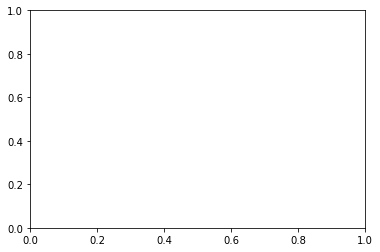

In [47]:
mean = np.mean(history.history['val_accuracy'])
std = np.std(history.history['val_accuracy'])
accuracy_plot(history)
loss_plot(history)